In [1]:
from __future__ import division
import random
from operator import attrgetter

In [2]:
def random_genome(allow_childless=True, max_food_to_children=100):
    while True:
        yield (
            random.random(), random.random(), 
            random.random() if allow_childless else 0.0,
            random.random() * max_food_to_children
        )

In [3]:
def person_factory(max_children=10, mature_age=3, max_age=10, rand_child_chance=0.01):
    class Person(object):

        (PERCENT_TO_SELF,
         PERCENT_TO_CHILDREN,
         CHANCE_CHILDLESS_CHILD,
         INIT_TO_CHILDREN,) = range(4)

        def __init__(self, genome, food, childless):
            self.genome = genome
            self.childless = childless
            self.food = food
            self.children = []
            self.siblings = ()
            self.age = 0
            self.dead = False

        def step(self, food, population):
            # Death
            if self.dead:
                self.age += 1
                return
            
            elif self.age > max_age:
                self.dead = True
                self.age += 1
                return
            
            # Food
            if self.age < mature_age:
                self.food += food

            elif food > 0:
                to_self = food * self.genome[self.PERCENT_TO_SELF]
                to_children = (food - to_self) * self.genome[self.PERCENT_TO_CHILDREN]
                to_kin = (food - to_self - to_children)

                self.food += to_self
                
                living_children = [
                    child 
                    for child in self.children
                    if not child.dead
                    and child.age < mature_age
                ]
                if living_children:
                    num_children = len(living_children)
                    for child in living_children:
                        child.food += to_children / num_children
                else:
                    to_kin += to_children

                living_kin = [
                    sibling 
                    for sibling in self.siblings
                    if not sibling.dead
                ] + [
                    child 
                    for sibling in self.siblings 
                    for child in sibling.children
                    if not child.dead
                ] + [
                    grandchild
                    for sibling in self.siblings
                    for child in sibling.children
                    for grandchild in child.children
                    if not grandchild.dead
                ]
                if living_kin:
                    num_kin = len(living_kin)
                    for kin in living_kin:
                        kin.food += to_kin / num_kin
                else:
                    self.food += to_kin

            else:
                self.food += food

            # Food check
            if self.food <= 0:
                self.dead = True
                
            elif self.age == mature_age and not self.childless:
                # Select mate from population
                partner = random.choice([
                    person
                    for person in population
                    if not person.dead
                    and person.age == self.age
                    and person not in self.siblings
                ])  # Randomly select mate
                
                # Create children, deciding if childless
                init_to_children = self.genome[self.INIT_TO_CHILDREN]
                for i in xrange(max_children):
                    if self.food < init_to_children:
                        break
                    self.food -= init_to_children
                    child_genome = [
                        max(random.gauss(combination, combination * 0.1), 0)
                        for combination in
                        ((g1 + g2) / 2
                         for g1, g2 in
                         zip(self.genome, partner.genome)
                        )
                    ]
                    child_genome[:3] = [min(g, 1) for g in child_genome[:3]]  # first three are probabilities
                    if random.random() < rand_child_chance:
                        child_genome = next(random_genome())
                    child = Person(
                        genome=child_genome,
                        food=init_to_children,
                        childless=random.random() < self.genome[self.CHANCE_CHILDLESS_CHILD]
                    )
                    self.children.append(child)
                    population.append(child)
                    
                for child in self.children:
                    child.siblings = frozenset(
                        sibling
                        for sibling in self.children
                        if sibling is not child
                    )
                 
            self.age += 1
            
    return Person

In [4]:
Person = person_factory()

In [9]:
INITIAL_FOOD = 50
AVERGE_FOOD = 5
INITIAL_POPULATION_SIZE = 10
MAX_POP_SIZE = 500
ITERATIONS = 1000

genomes = random_genome(allow_childless=False)
population = [Person(next(genomes), 100, False) for __ in xrange(INITIAL_POPULATION_SIZE)]

average_childlessness = [0.0]
average_food = [INITIAL_FOOD]
population_size = [INITIAL_POPULATION_SIZE]
for iteration in xrange(ITERATIONS):
    for person in population:
        person.step(random.gauss(AVERGE_FOOD, AVERGE_FOOD / 2), population)
    living_pop = [person for person in population if not person.dead]
    num_living = len(living_pop)
    population_size.append(num_living)
    average_childlessness.append(sum(
        person.genome[Person.CHANCE_CHILDLESS_CHILD]
        for person in living_pop
    ) / num_living)
    average_food.append(sum(
        person.food
        for person in living_pop
    ) / num_living)
    if not (iteration + 1) % 10:
        print iteration + 1, num_living, average_childlessness[-1], average_food[-1]
    if num_living > MAX_POP_SIZE:
        least_fit = sorted(population, key=attrgetter('food'))[:num_living - MAX_POP_SIZE]
        for person in least_fit:
            person.dead = True
    for person in population[:]:
        if person.dead:
            population.remove(person)

10 101 0.0 36.1324919587
20 140 0.0147734517386 37.9511957634
30 298 0.121264970487 34.4426940563
40 696 0.0701379042024 29.4783565578
50 500 0.034748438081 41.8601805519
60 459 0.0187907467075 46.984821678
70 914 0.0283672078563 29.9048525447
80 500 0.03066500348 46.3805096885
90 471 0.0346286550325 49.7386300088
100 900 0.0293038245383 31.2156221404
110 500 0.0217497275625 46.7645049582
120 470 0.020599424206 52.051185623
130 893 0.0113124643695 33.1425936216
140 500 0.0132023526036 53.4083573758
150 470 0.0179481648434 57.9838466028
160 858 0.0420332138434 36.521921855
170 500 0.0452296795482 55.2935555851
180 457 0.0348759333279 57.6971957165
190 788 0.0263759788061 37.1862367361
200 500 0.0222017109811 52.2878622168
210 451 0.0267242006428 53.4632053145
220 869 0.0330597672532 31.958702847
230 500 0.040250219762 45.6005878461
240 466 0.0561975037912 47.776334445
250 902 0.0882695194263 29.7129208458
260 500 0.087078456024 46.4259964268
270 457 0.0657049251301 47.5735893439
280 860

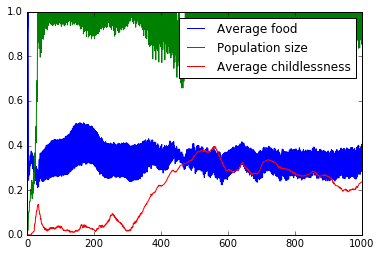

In [16]:
%matplotlib inline
from matplotlib import pyplot as pl
pl.plot([f / max(average_food) for f in average_food], label='Average food')
pl.plot([min(p, MAX_POP_SIZE) / MAX_POP_SIZE for p in population_size], label='Population size')
pl.plot(average_childlessness, label='Average childlessness')
pl.legend()
pl.show()

In [27]:
INITIAL_FOOD = 50
AVERGE_FOOD = 5
INITIAL_POPULATION_SIZE = 10
MAX_POP_SIZE = 500
ITERATIONS = 1000

genomes = random_genome(allow_childless=False)
population = [Person(next(genomes), 100, False) for __ in xrange(INITIAL_POPULATION_SIZE)]

average_childlessness = [0.0]
average_food = [INITIAL_FOOD]
population_size = [INITIAL_POPULATION_SIZE]
for iteration in xrange(ITERATIONS):
    for person in population:
        person.step(random.gauss(AVERGE_FOOD, AVERGE_FOOD / 2), population)
    living_pop = [person for person in population if not person.dead]
    if not living_pop:
        print 'All dead!'
        break
    num_living = len(living_pop)
    population_size.append(num_living)
    average_childlessness.append(sum(
        person.genome[Person.CHANCE_CHILDLESS_CHILD]
        for person in living_pop
    ) / num_living)
    average_food.append(sum(
        person.food
        for person in living_pop
    ) / num_living)
    if not (iteration + 1) % 25:
        print iteration + 1, num_living, average_childlessness[-1], average_food[-1]
    if num_living > MAX_POP_SIZE:
        least_fit = sorted(population, key=attrgetter('food'))[:num_living - MAX_POP_SIZE]
        for person in least_fit:
            person.dead = True
    for person in population[:]:
        if person.dead:
            population.remove(person)

25 91 0.00170484019465 41.441344551
50 81 0.00804237341925 53.5249815715
75 42 5.04267304851e-05 67.1818988052
100 29 1.43403846169e-07 61.2114308668
125 26 0.0321021074303 62.5953731005
150 16 0.0 47.5309970441
175 16 0.0369638898758 41.1171922628
200 20 0.0196333949754 42.9039198571
225 31 0.143000869778 38.5580091436
250 304 0.0563991256023 24.1210800424
275 500 0.0731252111352 41.3355294405
300 466 0.0769474296635 45.2317924466
325 800 0.0969762540976 31.7272268599
350 500 0.115079348125 47.4974017969
375 430 0.139043150705 47.3372352418
400 839 0.102246503115 28.79314274
425 500 0.0951480723287 42.70892264
450 450 0.118953995151 45.9802308591
475 771 0.142088863572 31.9377267868
500 500 0.145716387835 43.225074447
525 457 0.115151866399 44.9000185102
550 855 0.126245280113 28.9472652056
575 500 0.100615406849 44.7518621759
600 453 0.105947717285 43.7486814664
625 775 0.106437410796 32.6484903854
650 500 0.0969345481713 45.814661573
675 433 0.114888189463 49.1189810013
700 843 0.08

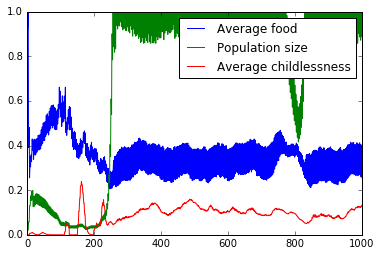

In [28]:
%matplotlib inline
from matplotlib import pyplot as pl
pl.plot([f / max(average_food) for f in average_food], label='Average food')
pl.plot([min(p, MAX_POP_SIZE) / MAX_POP_SIZE for p in population_size], label='Population size')
pl.plot(average_childlessness, label='Average childlessness')
pl.legend()
pl.show()

In [31]:
INITIAL_FOOD = 50
AVERGE_FOOD = 5
INITIAL_POPULATION_SIZE = 10
MAX_POP_SIZE = 500
ITERATIONS = 1000

genomes = random_genome(allow_childless=False)
population = [Person(next(genomes), 100, False) for __ in xrange(INITIAL_POPULATION_SIZE)]

average_childlessness = [0.0]
average_food = [INITIAL_FOOD]
population_size = [INITIAL_POPULATION_SIZE]
for iteration in xrange(ITERATIONS):
    for person in population:
        person.step(random.gauss(AVERGE_FOOD, AVERGE_FOOD / 2), population)
    living_pop = [person for person in population if not person.dead]
    if not living_pop:
        print 'All dead!'
        break
    num_living = len(living_pop)
    population_size.append(num_living)
    average_childlessness.append(sum(
        person.genome[Person.CHANCE_CHILDLESS_CHILD]
        for person in living_pop
    ) / num_living)
    average_food.append(sum(
        person.food
        for person in living_pop
    ) / num_living)
    if not (iteration + 1) % 25:
        print iteration + 1, num_living, average_childlessness[-1], average_food[-1]
    if num_living > MAX_POP_SIZE:
        least_fit = sorted(population, key=attrgetter('food'))[:num_living - MAX_POP_SIZE]
        for person in least_fit:
            person.dead = True
    for person in population[:]:
        if person.dead:
            population.remove(person)

25 25 0.0 49.8579678675
50 12 0.0 56.7308948431
75 9 0.00864219679489 59.2233707663
100 8 0.000845764451778 49.6798618965
125 8 3.91332314404e-05 52.762627469
150 3 0.0 51.3531824879
175 4 0.0 43.4178428159
200 4 0.0 39.7667111393
225 12 0.0 33.9967639137
250 1088 0.00365073696914 18.9533004056
275 500 0.0283845811675 34.8404281355
300 480 0.0378118854589 41.0108696888
325 1018 0.0310527301969 25.1805885779
350 500 0.0241200331855 39.0556950864
375 484 0.0217132137917 43.7254059426
400 1022 0.0215870272491 25.489689489
425 500 0.0416047172159 40.6367618076
450 478 0.0238915215576 43.1204140557
475 967 0.0278474967254 27.5155067847
500 500 0.0480675183488 42.5148148546
525 473 0.022540153933 47.1465758708
550 981 0.0144954817529 27.6274933101
575 500 0.0741811199959 44.7705017461
600 433 0.139616295584 52.0186159092
625 573 0.145579141778 36.4174261907
650 500 0.132600914311 44.6054738936
675 439 0.114069019762 44.892390171
700 854 0.107914704853 28.9989579879
725 500 0.0882389524306 43

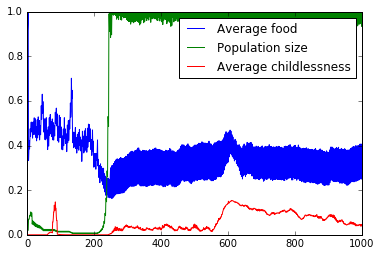

In [32]:
%matplotlib inline
from matplotlib import pyplot as pl
pl.plot([f / max(average_food) for f in average_food], label='Average food')
pl.plot([min(p, MAX_POP_SIZE) / MAX_POP_SIZE for p in population_size], label='Population size')
pl.plot(average_childlessness, label='Average childlessness')
pl.legend()
pl.show()

In [35]:
import math
[math.sin(x / 2) for x in xrange(20)]

[0.0,
 0.479425538604203,
 0.8414709848078965,
 0.9974949866040544,
 0.9092974268256817,
 0.5984721441039565,
 0.1411200080598672,
 -0.35078322768961984,
 -0.7568024953079282,
 -0.977530117665097,
 -0.9589242746631385,
 -0.7055403255703919,
 -0.27941549819892586,
 0.21511998808781552,
 0.6569865987187891,
 0.9379999767747389,
 0.9893582466233818,
 0.7984871126234903,
 0.4121184852417566,
 -0.0751511204618093]